In [43]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Dense, Dropout, Input, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, multilabel_confusion_matrix, roc_curve, auc

# Paths and constants
train_dir = "Training"
test_dir = "Testing"
model_name = "DarkNet53"
img_size = 224
batch_size = 32

In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [45]:
def conv_block(x, filters, kernel_size, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(x, filters):
    shortcut = x
    x = conv_block(x, filters // 2, 1)
    x = conv_block(x, filters, 3)
    x = Add()([shortcut, x])
    return x

def build_darknet53(input_shape=(img_size, img_size, 3), num_classes=4):
    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 32, 3)

    for filters, blocks in [(64, 1), (128, 2), (256, 8), (512, 8), (1024, 4)]:
        x = conv_block(x, filters, 3, strides=2)
        for _ in range(blocks):
            x = residual_block(x, filters)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model_darknet = build_darknet53()
model_darknet.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
model_darknet.summary()

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 224, 224, 32)      │             896 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 224, 224, 32)      │             128 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 224, 224, 32)      │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 112, 112, 64)      │          18,496 │ leaky_re_lu[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 112, 112, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 112, 112, 64)      │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 112, 112, 32)      │           2,080 │ leaky_re_lu_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 112, 112, 32)      │             128 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU)     │ (None, 112, 112, 32)      │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 112, 112, 64)      │          18,496 │ leaky_re_lu_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 112, 112, 64)      │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU)     │ (None, 112, 112, 64)      │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 112, 112, 64)      │               0 │ leaky_re_lu_1[0][0],       │
│                               │                           │                 │ leaky_re_lu_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 56, 56, 128)       │          73,85

 Total params: 40,642,596 (155.04 MB)

 Trainable params: 40,606,884 (154.90 MB)

 Non-trainable params: 35,712 (139.50 KB)

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history_darknet = model_darknet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, lr_reduce]
)

model_darknet.save(f"{model_name}.h5")

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1640s 10s/step - accuracy: 0.5136 - loss: 1.6214 - val_accuracy: 0.2500 - val_loss: 1.7742 - learning_rate: 1.0000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1557s 10s/step - accuracy: 0.7073 - loss: 0.7570 - val_accuracy: 0.1833 - val_loss: 4.4634 - learning_rate: 1.0000e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1679s 11s/step - accuracy: 0.7513 - loss: 0.6624 - val_accuracy: 0.3075 - val_loss: 2.0636 - learning_rate: 1.0000e-04
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1665s 11s/step - accuracy: 0.8121 - loss: 0.5492 - val_accuracy: 0.7100 - val_loss: 0.7735 - learning_rate: 2.0000e-05
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1600s 11s/step - accuracy: 0.8498 - loss: 0.4207 - val_accuracy: 0.7717 - val_loss: 0.6095 - learning_rate: 2.0000e-05
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1579s 11s/step - accuracy: 0.8570 - loss: 0.4057 - val_accuracy: 0.8200 - val_loss: 0.5330 - learning_rate: 2.0000e-05
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 1722s 

In [47]:
loss, acc = model_darknet.evaluate(test_generator)
y_true = test_generator.classes
y_pred_probs = model_darknet.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7615 - loss: 0.6753
38/38 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step


In [48]:
cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
mcm = multilabel_confusion_matrix(y_true, y_pred)

tp = mcm[:, 1, 1].sum()
tn = mcm[:, 0, 0].sum()
fp = mcm[:, 0, 1].sum()
fn = mcm[:, 1, 0].sum()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, multi_class='ovr')

print(f"{model_name} Accuracy     : {acc:.4f}")
print(f"Precision              : {cr['macro avg']['precision']:.4f}")
print(f"Recall                 : {cr['macro avg']['recall']:.4f}")
print(f"F1-Score               : {cr['macro avg']['f1-score']:.4f}")
print(f"Specificity            : {specificity:.4f}")
print(f"ROC AUC                : {roc_auc:.4f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

DarkNet53 Accuracy     : 0.8425
Precision              : 0.8503
Recall                 : 0.8425
F1-Score               : 0.8383
Specificity            : 0.9475
ROC AUC                : 0.9712
TP: 1011, TN: 3411, FP: 189, FN: 189


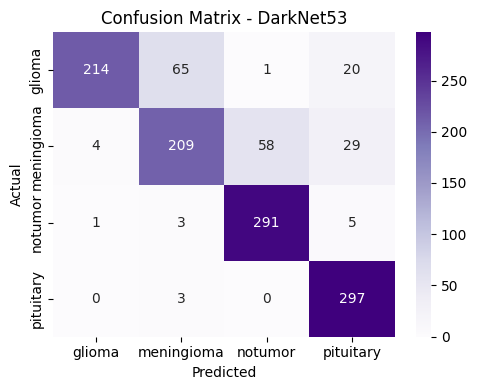

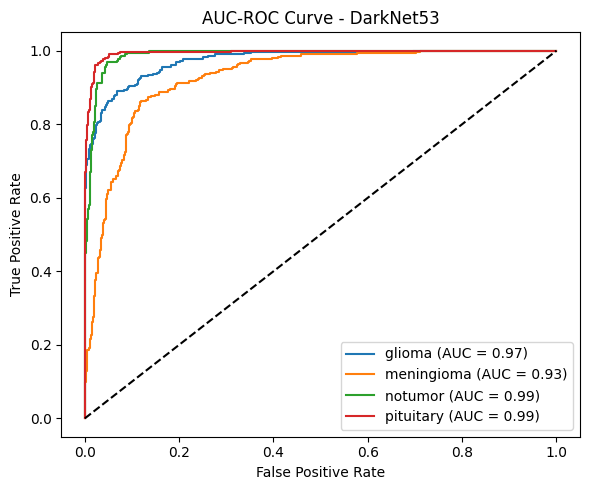

In [49]:
# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"conf_matrix_{model_name}.png")
plt.show()

# AUC-ROC Curve
plt.figure(figsize=(6, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true)[:, i], y_pred_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"AUC-ROC Curve - {model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"auc_roc_{model_name}.png")
plt.show()

In [50]:
result_dict = {
    "Model": [model_name],
    "Accuracy": [acc],
    "Precision": [cr['macro avg']['precision']],
    "Recall": [cr['macro avg']['recall']],
    "Specificity": [specificity],
    "F1-Score": [cr['macro avg']['f1-score']],
    "AUC-ROC": [roc_auc],
    "TP": [tp],
    "TN": [tn],
    "FP": [fp],
    "FN": [fn]
}

results_df = pd.DataFrame(result_dict)
results_file = "all_model_results.csv"

if os.path.exists(results_file):
    results_df.to_csv(results_file, mode='a', index=False, header=False)
else:
    results_df.to_csv(results_file, index=False)

print(f"✅ Results saved to {results_file}")

✅ Results saved to all_model_results.csv
